In [2]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

from lmfit import Model, minimize, Parameters, fit_report
from lmfit.models import LinearModel

import os
import warnings
warnings.filterwarnings('ignore')


# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
order36_data_list = []

index0 = 22 # fits index start, min >= 1, max <= n
index1 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + index0
    if n>= index0 and n < 10:
        hdu_data_order36 = fits.getdata(filepath + 'order36/new_frame/jun02s000' + '{}_order36.fits'.format(n), ext=0)
        order36_data_list.append(hdu_data_order36)
    elif n>= 10 and n < 100:
        hdu_data_order36 = fits.getdata(filepath + 'order36/new_frame/jun02s00' + '{}_order36.fits'.format(n), ext=0)
        order36_data_list.append(hdu_data_order36)
    elif n >= 100 and n < index1:
        hdu_data_order36 = fits.getdata(filepath + 'order36/new_frame/jun02s0' + '{}_order36.fits'.format(n), ext=0)
        order36_data_list.append(hdu_data_order36)
    elif n >= index1:
        break
order36_data = np.array(order36_data_list)

# load waverange
waverange36 = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# load spectral resolution
R36 = 73194.84858495607
R = np.mean((R36))


# obtain average flat field
avg_flat_order36 = np.mean((order36_data[32-index0], 
                              order36_data[33-index0], 
                              order36_data[34-index0], 
                              order36_data[35-index0], 
                              order36_data[36-index0], 
                              order36_data[37-index0], 
                              order36_data[38-index0], 
                              order36_data[39-index0], 
                              order36_data[40-index0], 
                              order36_data[41-index0],), axis=0)

# obtain average flat lamp off
avg_dark_order36 = np.mean((order36_data[22-index0], 
                                 order36_data[23-index0], 
                                 order36_data[24-index0],
                                 order36_data[25-index0], 
                                 order36_data[26-index0], 
                                 order36_data[27-index0], 
                                 order36_data[28-index0], 
                                 order36_data[29-index0], 
                                 order36_data[30-index0], 
                                 order36_data[31-index0],), axis=0)

# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= index0 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < index1:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= index1:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(data, fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = data[fn_sky1-index0]
    sky2 = data[fn_sky2-index0]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final


# frame number of target spectra
fn_spec = 61

sky36 = scale_sky_frame(order36_data, fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
target_spec36 = order36_data[fn_spec-index0]

reduced_spec36 = (target_spec36 - sky36) / (avg_flat_order36 - avg_dark_order36)
reduced_spec36[reduced_spec36<0] = 0

In [3]:
spec36_reducelist = []

for i in range(60, 104):
    sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)
    
    if i in sky_frame:
        continue
    elif i not in sky_frame:
        skyframe36 = scale_sky_frame(order36_data, i)
    
        reduce_spec36 = (order36_data[i-index0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
    
        spec36_reducelist.append(reduce_spec36)
spec36_reduced = np.array(spec36_reducelist)

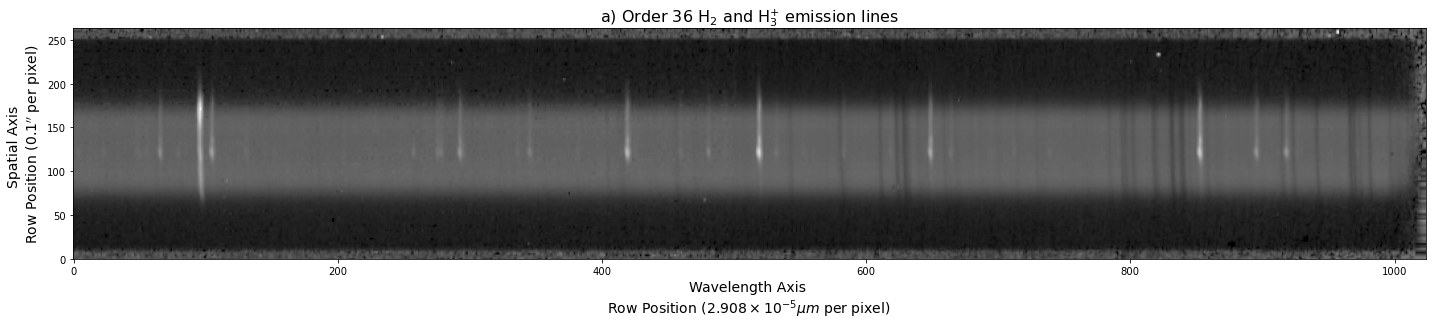

In [4]:
fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(211)
# plt.imshow(reduced_spec36, aspect='auto', cmap='gist_gray', extent=[waverange36[0],waverange36[-1],264,0], norm=colors.PowerNorm(gamma=0.4))
plt.imshow(reduced_spec36, aspect='auto', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.4))
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ticklabel_format(useOffset=False)
plt.title('a) Order 36 H$_2$ and H$_3^{+}$ emission lines', fontsize=16)
plt.gca().invert_yaxis()
# plt.colorbar(extend='max',

(2.1192026138305664, 2.148951530456543)

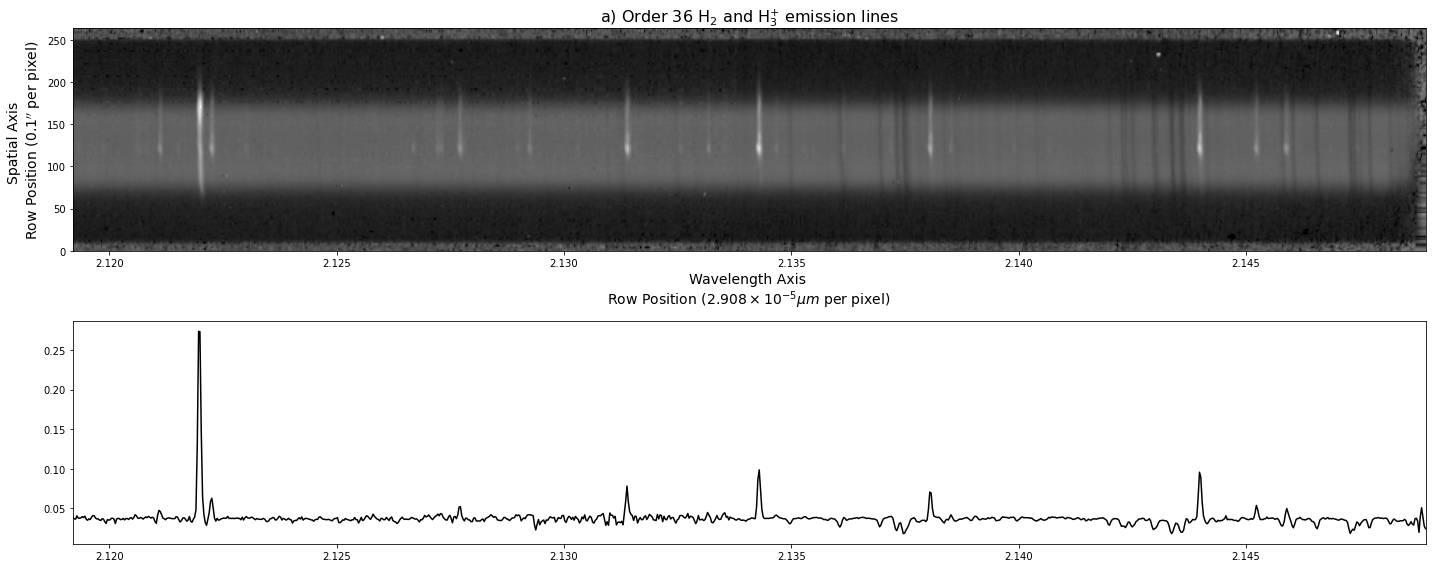

In [61]:
fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(reduced_spec36, aspect='auto', cmap='gist_gray', extent=[waverange36[0],waverange36[-1],264,0], norm=colors.PowerNorm(gamma=0.4))
# plt.imshow(reduced_spec36, aspect='auto', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.4))
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ticklabel_format(useOffset=False)
plt.title('a) Order 36 H$_2$ and H$_3^{+}$ emission lines', fontsize=16)
plt.gca().invert_yaxis()
# plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
# plt.colorbar(extend='max', aspect=15, pad=0.01).set_label(label='CCD Counts', size=14)

fig.add_subplot(212)
plt.plot(waverange36, reduced_spec36[160], 'k')
plt.xlim(waverange36[0], waverange36[-1])

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 40
    # variables        = 6
    chi-square         = 0.035829686
    reduced chi-square = 0.00105381
    Akaike info crit   = -268.714319
    Bayesian info crit = -258.581042
[[Variables]]
    a0:  0.26997794 +/- 227.010199 (84084.72%) (init = 0.27)
    a1:  2.12200006 +/- 0.61607388 (29.03%) (init = 2.122)
    a2:  0.00100071 +/- 1.3214e-04 (13.20%) (init = 0.001)
    a3:  0.04001030 +/- 0.02619912 (65.48%) (init = 0.04)
    a4:  1.0827e-05 +/- 0.01558785 (143970.17%) (init = 0)
    a5:  3.8551e-06 +/- 0.00342856 (88935.75%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a1) =  1.000
    C(a3, a4) = -0.848
    C(a4, a5) = -0.655
    C(a2, a5) =  0.633
    C(a0, a5) = -0.512
    C(a1, a5) = -0.511
    C(a0, a4) =  0.356
    C(a1, a4) =  0.355
    C(a0, a2) = -0.235
    C(a1, a2) = -0.235
    C(a2, a4) = -0.209
    C(a3

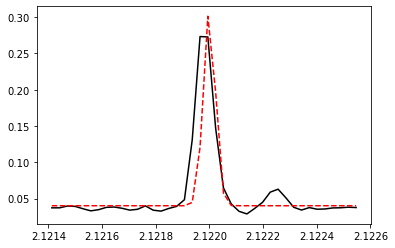

In [62]:
xx = waverange36[76:116]
y = reduced_spec36[160][76:116]

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=0.27)
g1_params.add('a1', value=2.122)
g1_params.add('a2', value=0.001)
g1_params.add('a3', value=0.04)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(y, g1_params, x=xx)
except ValueError:
    print('ValueError occured')

print(g1_result.fit_report())

plt.plot(xx, y, 'k')
plt.plot(xx, g1_result.best_fit, 'r--', label='g1 best fit')
# # plt.xlim(2.13,2.135)

print(g1_result.params['a1'].value)

In [6]:
stack_list36 = []

for i in range(np.size(spec36_reduced, axis=0)-1):
    if i!=15:
        stack_list36.append(np.sum((spec36_reduced[i], spec36_reduced[i+1]), axis=0))
    
spec36_stacked = np.array(stack_list36)
# spec36_stacked = np.array(spec36_reduced)

st_list = []
smooth = []
for i in range(np.size(spec36_stacked, axis=0)):
    s1a = np.delete(spec36_stacked[i], np.s_[230:], 1)
    s1b = np.delete(s1a, np.s_[:130], 1)
    
    stt = s1b#+s2b+s3b
    
    smoo = []
    for j in range(2, len(stt)-2):
        addup = np.mean((stt[j-2],stt[j-1],stt[j],stt[j+1],stt[j+2]), axis=0)
        smoo.append(addup)
#         smoo[j] = addup
    smooth = np.array(smoo)
#     print(smooth.shape)
    
    st_list.append(stt)
st = np.array(st_list)

In [7]:
# create empty list to collect result
background_scan = []

fn0 = 0
fn1 = np.size(st,0)

upper = 245
lower = 10

print('BLANK LOOP START')
for fn in range(fn0, fn1):
    blank = np.zeros(300)
    
    stack = st[fn]
    
    blank = np.zeros(300)      
            
    # fit gaussian to selected range of spatial axis of a frame
    for i in range(lower, upper):               
            blank[i] = np.median(stack[i])
    
    # Collect fitting parameters of each frame number   
    background_scan.append(blank)
    
print('DONE')

BLANK LOOP START
DONE


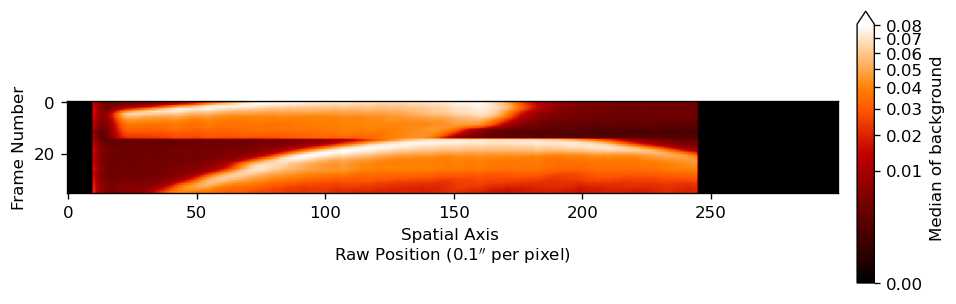

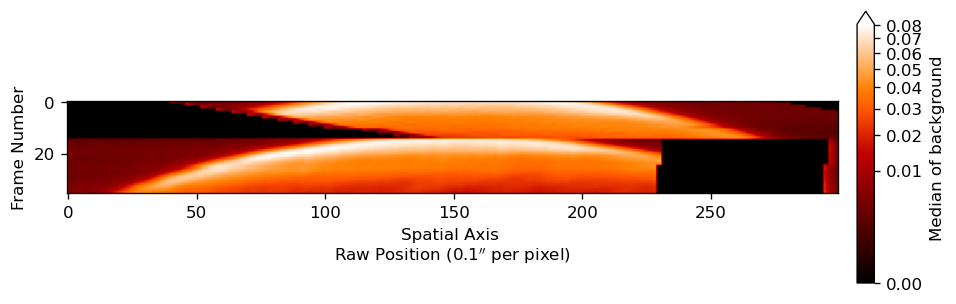

In [8]:
backgr_raw = np.vstack(background_scan)
# backgr = np.delete(backgr, np.s_[132:], 1)
# backgr = np.delete(backgr, np.s_[:7], 1)

backgr1 = np.roll(backgr_raw[:6], 30, axis=1)
backgr2 = np.roll(backgr_raw[6:11], 30, axis=1)
backgr3 = np.roll(backgr_raw[11:15], 39, axis=1)
backgr4 = np.roll(backgr_raw[15:25], -14, axis=1)
backgr5 = np.roll(backgr_raw[25:], -16, axis=1)
# backgr4 = scipy.ndimage.shift(backgr4, -15.5, order=5)

backgr_shifted = np.vstack((backgr1,backgr2,backgr3,backgr4,backgr5))
# backgr_shifted = np.flip(backgr_shifted, axis=1)

for i in range(15):
    backgr_shifted[i,:] = scipy.ndimage.shift(backgr_shifted[i,:], i*6, order=3)

# backgr_shifted = np.flip(backgr_shifted, axis=1)
    
# for i in range(25,36):
#     backgr_shifted[i,:] = scipy.ndimage.shift(backgr_shifted[i,:], i*(-1), order=3)


plt.figure(figsize=(10,3))
plt.imshow(backgr_raw, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.4))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
# plt.title(r'a) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Median of background')

plt.figure(figsize=(10,3))
plt.imshow(backgr_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.4))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
# plt.title(r'a) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Median of background')

In [91]:
backgr_raw = np.vstack(background_scan)

backgr_shifted = np.vstack((backgr1,backgr2,backgr3,backgr4,backgr5))

for i in range(15):
    backgr_shifted[i,:] = scipy.ndimage.shift(backgr_shifted[i,:], i*6, order=3)

backgr_shifted = np.flip(backgr_shifted, axis=1)

for i in range(6):
    limbs = backgr_shifted[i,:]
#     plt.figure()
#     plt.plot(limbs)

    limbs[limbs<np.amax(limbs)*0.2] = np.amax(limbs)*0.2
    limbs[limbs>np.amax(limbs)*0.6] = np.amax(limbs)*0.6
    
    peak = np.linspace(0, 299, 300)[np.where(np.gradient(limbs)==np.max(np.gradient(limbs)))]
    trough = np.linspace(0, 299, 300)[np.where(np.gradient(limbs)==np.min(np.gradient(limbs)))]

    print(peak, trough)
    print((float(peak) + float(trough))/2)
    

#     plt.figure()
#     plt.plot(limbs)
#     plt.figure()
#     plt.plot(np.gradient(limbs))

[97.] [203.]
150.0
[90.] [210.]
150.0
[83.] [217.]
150.0
[76.] [220.]
148.0
[73.] [225.]
149.0
[67.] [220.]
143.5


(array([99.]), array([251.]))

175.0

In [12]:
gmodel = Model(gaussian_fit)

gparams = gmodel.make_params()
gparams.add('a0', value=0.16)
gparams.add('a1', value=33)
gparams.add('a2', value=3)
gparams.add('a3', value=0)
gparams.add('a4', value=0)
gparams.add('a5', value=0)

gresult = gmodel.fit(b[70], gparams, x=np.linspace(0, 64, 65))

print(fit_report(gresult, min_correl=0.25))

plt.figure()
plt.plot(np.linspace(0, 64, 65), b[70], 'k.', label='data')
plt.plot(np.linspace(0, 64, 65), gresult.best_fit, 'r-', lw=1, label='best fit')
plt.xlim(10,50)
plt.xlabel('Wavelength Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.ylabel('CCD Counts')
plt.legend()

NameError: name 'b' is not defined

In [ ]:
fig = plt.figure(figsize=(12,5), tight_layout=True)

fig.add_subplot(121)
plt.imshow(b, aspect='equal', cmap='afmhot')
plt.axhline(y=70, c='white', ls='--', lw=0.6)
plt.xlabel('Wavelength Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.title('a)', loc='left')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', label='CCD Counts')

fig.add_subplot(122)
plt.plot([34, 34], [0.04, 0.16], color='k', linestyle='--', dashes=(5,10), lw=1)
plt.plot([20, 34], [0.16, 0.16], color='k', linestyle='--', dashes=(5,10), lw=1)
# plt.plot([20, 20], [0.04, 0.16], color='b', linestyle='-', lw=1)
plt.arrow(20, 0.04, 0, 0.12, head_width=0.5, head_length=0.004, fc='b', ec='b', length_includes_head=True)
plt.arrow(0, 0.04, 34, 0, head_width=0.004, head_length=0.5, width=0.0001, fc='b', ec='b', length_includes_head=True)
plt.arrow(32.65, 0.1, 2.6, 0, head_width=0.004, head_length=0.3, width=0.00005, fc='b', ec='b', length_includes_head=True)
plt.arrow(35.35, 0.1, -2.65, 0, head_width=0.004, head_length=0.3, width=0.00005, fc='b', ec='b', length_includes_head=True)
plt.text(18, 0.1, '$\mathrm{A_0}$', color='b')
plt.text(31, 0.03, '$\mathrm{A_1}$', color='b')
plt.text(36, 0.1, '$\mathrm{FWHM}$', color='b')
plt.plot(np.linspace(0, 64, 65), b[70], 'k.', label='data')
plt.plot(np.linspace(0, 64, 65), gresult.best_fit, 'r-', lw=1.5, label='best fit')
plt.xlim(10,50)
plt.xlabel('Wavelength Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.ylabel('CCD Counts')
plt.title('b)', loc='left')
plt.legend()

In [ ]:
modeA = nirspec_data_array[43-start_nirspec] +\
        nirspec_data_array[46-start_nirspec] +\
        nirspec_data_array[47-start_nirspec] +\
        nirspec_data_array[50-start_nirspec]
modeB = nirspec_data_array[44-start_nirspec] +\
        nirspec_data_array[45-start_nirspec] +\
        nirspec_data_array[48-start_nirspec] +\
        nirspec_data_array[49-start_nirspec]                              
star_exp_time = 20

modeAB = ((modeA - modeB)/4)/(average_flat_field - average_flat_lamp_off)/star_exp_time
modeAB = np.roll(modeAB, -3, axis=0)

plt.figure(figsize=(10,2))
plt.imshow(modeAB, aspect='auto', cmap='gist_gray')
plt.title('Order 36 Spectra of HD 109840 observed on 2nd June 2017')
plt.xlabel('Wavelength Axis \nRow Position'+r'($2.908 \times 10^{-5} \mu m$ per pixel)')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)')
# plt.ticklabel_format(useOffset=False)
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.015, label='CCD Counts s$^{-1}$')
# plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')

In [ ]:
modeAB.shape

In [ ]:
top = np.linspace(0, np.size(modeAB,0)-1, np.size(modeAB,0))[np.max(modeAB.T[200]) == modeAB.T[200]]
bot = np.linspace(0, np.size(modeAB,0)-1, np.size(modeAB,0))[np.min(modeAB.T[200]) == modeAB.T[200]]

(bot-top)[0]

In [ ]:
bot,top

In [ ]:
120/64*141

In [ ]:
flux_model = Model(gaussian_fit)

flux_params = flux_model.make_params()
flux_params.add('a0', value=0.005, min=0, max=0.05)
flux_params.add('a1', value=68, min=65, max=71)
flux_params.add('a2', value=2, min=0.5, max=5)
flux_params.add('a3', value=0)
flux_params.add('a4', value=0)
flux_params.add('a5', value=0)

lower_flux = 0
upper_flux = 1024

spat_axis = np.linspace(0,263,264)

HD109840_a0 = np.zeros(np.size(modeAB,1))
HD109840_a2 = np.zeros(np.size(modeAB,1))

for i in range(lower_flux, upper_flux):
#     if i == 492:
#         continue
    try:
        flux_fit_result = flux_model.fit(modeAB.T[i], flux_params, x=spat_axis)
    except ValueError:
        print('ValueError occured at i=' + str(i))
#     plt.figure()
#     plt.title('i='+str(i))
#     plt.plot(spat_axis, modeAB.T[i])
#     plt.plot(spat_axis, flux_fit_result.best_fit, 'r-', label='best fit')
    
    HD109840_a0[i] = flux_fit_result.params['a0'].value
    HD109840_a2[i] = flux_fit_result.params['a2'].value
    
# HD109840_a0[HD109840_a0<0.05] = 0.1
# HD109840_a2[HD109840_a2<0] = 0
HD109840_a0[HD109840_a0<(np.mean(HD109840_a0)-4*np.std(HD109840_a0))] = np.mean(HD109840_a0)
HD109840_a2[HD109840_a2<(np.mean(HD109840_a2)-4*np.std(HD109840_a2))] = np.mean(HD109840_a2)

In [ ]:
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10
m_lambda = 6.787 # Kmag HD 109840
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)
F_bb = F_a0 * ((lambda_aw/waverange)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange*T)) - 1))

HD109840_fwhm = HD109840_a2*(np.sqrt(2*np.log(2))*2)
F_obs = HD109840_a0 * HD109840_fwhm

Fc = F_bb/F_obs

# HD131885_fwhm = HD131885_a2*(np.sqrt(2*np.log(2))*2)
# F_obs2 = HD131885_a0 * HD131885_fwhm

# Fc2 = F_bb/(F_obs2)

width = np.size(sky_subtracted, axis=0)
length = np.size(sky_subtracted, axis=1)

slit_area = 0.1*width * 2.908e-5*length

Fjc = sky_subtracted * Fc * 4.2535e10 / slit_area
# plt.figure(figsize=(10,2))
# plt.imshow(Fjc**0.4, aspect='auto', extent=[waverange[0], waverange[-1], 140, 0], cmap='gist_gray')
# plt.plot(waverange[:995], Fc2[:995], 'r-', label='Model')
# plt.plot(waverange[:1000], Fc[:1000], 'b-', label='Model')
# plt.legend()
# plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
# plt.gca().invert_yaxis()
# plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
# plt.colorbar(extend='max', aspect=15, pad=0.02, label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)')

plt.figure()
# plt.plot(waverange[:1000], F_bb[:1000], 'k-', lw=0.3)
# plt.plot(waverange[:1000], F_obs[:1000], 'k-', lw=0.3)
plt.plot(waverange[:1000], Fc[:1000], 'k-', lw=0.3)
plt.xlim(waverange[0], waverange[1000])
# plt.plot(waverange, Fjc[60]-np.median(Fjc[60]), label='median subtracted')
plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Flux (W m$^{-2}$ $\mu$m$^{-1}$)')
# plt.ylabel('CCD Counts s$^{-1}$')
# plt.ylabel('CCD Counts')
# plt.ylabel('Flux (W sr$^{-1}$ m$^{-2}$ $\mu$m$^{-1}$)')
plt.ylabel('Flux ($\mathrm{Wm^{-2} \mu m^{-1} count^{-1} s}$)')
# plt.legend()

In [ ]:
plt.figure(figsize=(10,2))
plt.imshow(Fjc, aspect='auto', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.4))
plt.xlabel('Wavelength Axis \nRow Position'+r'($2.908 \times 10^{-5} \mu m$ per pixel)')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)')
# plt.ticklabel_format(useOffset=False)
plt.title('a) Average H$_2$ and H$_3^{+}$ emission lines')
# plt.gca().invert_yaxis()
# plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')

In [ ]:
a = np.delete(Fjc, np.s_[120:], 1)
b = np.delete(a, np.s_[:80], 1)

plt.figure()
plt.imshow(b*1e11, aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.4))
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')

In [ ]:
plt.plot(b[90])

In [ ]:
fig = plt.figure(figsize=(12,10), tight_layout=True)
# ax = fig.add_subplot(111, frameon=True)
# ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.add_subplot(311)
plt.imshow(target_spec, aspect='auto', cmap='gist_gray')
plt.title('a)', loc='left')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')
plt.title('Sky Subtraction Process', fontsize=18)
fig.add_subplot(312)
plt.imshow(sky_total, aspect='auto', cmap='gist_gray')
plt.title('b)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)', fontsize=16)
plt.gca().invert_yaxis()
fig.add_subplot(313)
plt.imshow(target_spec-sky_total, aspect='auto', cmap='gist_gray')
plt.title('c)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')
plt.xlabel('Wavelength Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)', fontsize=16)
plt.gca().invert_yaxis()
# ax.set_xlabel('Wavelength Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
# ax.set_ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')

In [ ]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# confirm start and end frame number
fn_start = 60
fn_end = 104
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# create empty list to collect result
h2_a0_map = []
h2_a1_map = []
h2_a2_map = []
# utc = []


print('H2 LOOP START')
# scan selected range of frames
for fn in range(fn_start, fn_end):
    # check if selected frame is a sky frame
    if fn in sky_frame:
        print('Frame Number = ' + str(fn) + '(Sky Frame)')
        continue
    # perform sky subtraction
    skyfinal = scale_sky_frame(fn)
    sky_subtract = (nirspec_data_array[fn-start_nirspec] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    fjc = sky_subtract * Fc * slit_area
#     utc.append(nirspec_utc[fn-start_nirspec])
    
    # select waverange for gaussian fit
#     a = np.delete(sky_subtract, np.s_[120:], 1)
    a = np.delete(fjc, np.s_[120:], 1)
    b = np.delete(a, np.s_[:80], 1)
    
    # define new wavlength axis
#     waveaxis = waverange[80:120]*10**5
    pixel = np.linspace(0, np.size(b, 1), np.size(b, 1))
    
    # partition frame numbers to account for change in spatial axis       
    if fn >= fn_start and fn < fn_end:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 250
        lower_h2 = 10

        h2_a0 = np.zeros(300)
        h2_a1 = np.zeros(300)
        h2_a2 = np.zeros(300)
    
            
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):               
            # different initial guess for different spatial range
            if i >= lower_h2 and i < upper_h2:
            # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1, min=0, max=3)
                h2_params.add('a1', value=16, min=13, max=19)
                h2_params.add('a2', value=1, min=0, max=4)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit((b[i])*1e11, h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
#                 plt.figure()
#                 plt.title('i='+str(i))
#                 plt.plot(pixel, b[i]*10**5)
#                 plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
                
                # collect fitting parameters
                h2_a0[i] = h2_fit_result.params['a0'].value
                h2_a1[i] = h2_fit_result.params['a1'].value
                h2_a2[i] = h2_fit_result.params['a2'].value
                
    
    # Collect fitting parameters of each frame number   
    h2_a0_map.append(h2_a0)
    h2_a1_map.append(h2_a1)
    h2_a2_map.append(h2_a2)
       
print('DONE')

In [ ]:
h2a0 = np.vstack((h2_a0_map))
h2a1 = np.vstack((h2_a1_map)) + 80
h2a2 = np.vstack((h2_a2_map))

h2_fwhm = h2a2*(np.sqrt(2*np.log(2))*2)
h2_int = h2a0*h2_fwhm/1e11

h2_wl = h2a1
h2_los = h2_wl/R*3e5

h2_int1 = np.roll(h2_int[:6], 26, axis=1)
h2_int2 = np.roll(h2_int[6:11], 25, axis=1)
h2_int3 = np.roll(h2_int[11:16], 32, axis=1)
h2_int4 = np.roll(h2_int[16:27], -15, axis=1)
h2_int5 = np.roll(h2_int[27:], -17, axis=1)
h2_int_shifted = np.vstack((h2_int1, h2_int2, h2_int3, h2_int4, h2_int5))

for i in range(16):
    h2_int_shifted[i,:] = scipy.ndimage.shift(h2_int_shifted[i,:], i*6, order=3)
    
h2_los1 = np.roll(h2_los[:6], 26, axis=1)
h2_los2 = np.roll(h2_los[6:11], 25, axis=1)
h2_los3 = np.roll(h2_los[11:16], 32, axis=1)
h2_los4 = np.roll(h2_los[16:27], -15, axis=1)
h2_los5 = np.roll(h2_los[27:], -17, axis=1)
h2_los_shifted = np.vstack((h2_los1, h2_los2, h2_los3, h2_los4, h2_los5))

for i in range(16):
    h2_los_shifted[i,:] = scipy.ndimage.shift(h2_los_shifted[i,:], i*6, order=3)
    
    
h2_int_shifted = np.flip(h2_int_shifted, axis=1)
h2_int_shifted[h2_int_shifted<0]=0
h2_los_shifted = np.flip(h2_los_shifted, axis=1)

h2_los_rel = h2_los_shifted-np.median(h2_los_shifted, axis=0)[149]
h2_los_rel[h2_los_rel>6] = 6
h2_los_rel[h2_los_rel<-6] = -6

fig = plt.figure(figsize=(18,6), tight_layout=True)

# plt.figure(figsize=(15,2))
fig.add_subplot(211)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.ylabel('Frame Number', fontsize=12)
# plt.title(r'a) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.title('a) H$_2$ Order 36', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01, label='Intensity (Wm$^{-2}$sr$^{-1}$)')

fig.add_subplot(212)
plt.imshow(h2_los_rel, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.ylabel('Frame Number', fontsize=12)
# plt.title(r'b) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.title('b) H$_2$ Order 36', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01, label='LOS Velocity (km/s)')

In [ ]:
# backgr_shifted = np.vstack(background_scan)

limbs = h2_int_shifted[16,:]
plt.figure()
plt.plot(limbs)

limbs[limbs<np.amax(limbs)*0.2] = np.amax(limbs)*0.2
limbs[limbs>np.amax(limbs)*0.6] = np.amax(limbs)*0.6

plt.figure()
plt.plot(limbs)
plt.figure()
plt.plot(np.gradient(limbs))

In [ ]:
peak = np.linspace(0, 299, 300)[np.where(np.gradient(limbs)==np.max(np.gradient(limbs)))]
trough = np.linspace(0, 299, 300)[np.where(np.gradient(limbs)==np.min(np.gradient(limbs)))]

peak, trough

In [ ]:
(float(peak) + float(trough))/2

In [ ]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# confirm start and end frame number
fn_start = 60
fn_end = 104
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# create empty list to collect result
h3p01_a0_map = []
h3p01_a1_map = []
h3p01_a2_map = []


print('H3P LOOP START')
# scan selected range of frames
for fn in range(fn_start, fn_end):
    # check if selected frame is a sky frame
    if fn in sky_frame:
        print('Frame Number = ' + str(fn) + '(Sky Frame)')
        continue
    # perform sky subtraction
    skyfinal = scale_sky_frame(fn)
    sky_subtract = (nirspec_data_array[fn-start_nirspec] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    fjc = sky_subtract * Fc * slit_area
    
    # select waverange for gaussian fit
    a = np.delete(fjc, np.s_[550:], 1)
    b = np.delete(a, np.s_[:500], 1)
    b[b<0] = 0
    b=b*1e11
    
    # define new wavlength axis
#     waveaxis = waverange[80:120]*100000
    pixel = np.linspace(0, np.size(b, 1), np.size(b, 1))
    
    # partition frame numbers to account for change in spatial axis       
    if fn >= fn_start and fn < fn_end:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h3p01 = 250
        lower_h3p01 = 10

        h3p01_a0 = np.zeros(300)
        h3p01_a1 = np.zeros(300)
        h3p01_a2 = np.zeros(300)
            
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h3p01, upper_h3p01):               
            # different initial guess for different spatial range
            if i >= lower_h3p01 and i < upper_h3p01:
            # create lmfit model with defined gaussian
                h3p01_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h3p01_params = h3p01_model.make_params()
                h3p01_params.add('a0', value=0.1, min=0, max=0.4)
                h3p01_params.add('a1', value=19, min=16.5, max=22)
                h3p01_params.add('a2', value=1, min=0, max=4)
                h3p01_params.add('a3', value=0)
                h3p01_params.add('a4', value=0)
                h3p01_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h3p01_fit_result = h3p01_model.fit(b[i], h3p01_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
#                     plt.figure()
#                     plt.title('i='+str(i))
#                     plt.plot(pixel, b[i])
#                     plt.plot(pixel, h3p01_fit_result.best_fit, 'r-', label='best fit')
                
                # collect fitting parameters
                h3p01_a0[i] = h3p01_fit_result.params['a0'].value
                h3p01_a1[i] = h3p01_fit_result.params['a1'].value
                h3p01_a2[i] = h3p01_fit_result.params['a2'].value
    
    # Collect fitting parameters of each frame number   
    h3p01_a0_map.append(h3p01_a0)
    h3p01_a1_map.append(h3p01_a1)
    h3p01_a2_map.append(h3p01_a2)
    
print('DONE')

In [ ]:
h3p01a0 = np.vstack((h3p01_a0_map))
h3p01a1 = np.vstack((h3p01_a1_map)) + 500
h3p01a2 = np.vstack((h3p01_a2_map))

h3p01_fwhm = h3p01a2*(np.sqrt(2*np.log(2))*2)
h3p01_int = h3p01a0*h3p01_fwhm/1e11

h3p01_wl = h3p01a1
h3p01_los = h3p01_wl/R*3e5

h3p01_int1 = np.roll(h3p01_int[:6], 26, axis=1)
h3p01_int2 = np.roll(h3p01_int[6:11], 25, axis=1)
h3p01_int3 = np.roll(h3p01_int[11:16], 32, axis=1)
h3p01_int4 = np.roll(h3p01_int[16:27], -15, axis=1)
h3p01_int5 = np.roll(h3p01_int[27:], -17, axis=1)
h3p01_int_shifted = np.vstack((h3p01_int1, h3p01_int2, h3p01_int3, h3p01_int4, h3p01_int5))

for i in range(16):
    h3p01_int_shifted[i,:] = scipy.ndimage.shift(h3p01_int_shifted[i,:], i*6, order=3)
    
h3p01_los1 = np.roll(h3p01_los[:6], 26, axis=1)
h3p01_los2 = np.roll(h3p01_los[6:11], 25, axis=1)
h3p01_los3 = np.roll(h3p01_los[11:16], 32, axis=1)
h3p01_los4 = np.roll(h3p01_los[16:27], -15, axis=1)
h3p01_los5 = np.roll(h3p01_los[27:], -17, axis=1)
h3p01_los_shifted = np.vstack((h3p01_los1, h3p01_los2, h3p01_los3, h3p01_los4, h3p01_los5))

for i in range(16):
    h3p01_los_shifted[i,:] = scipy.ndimage.shift(h3p01_los_shifted[i,:], i*6, order=3)
    
    
h3p01_int_shifted = np.flip(h3p01_int_shifted, axis=1)
h3p01_int_shifted[h3p01_int_shifted<0]=0
h3p01_los_shifted = np.flip(h3p01_los_shifted, axis=1)

h3p01_los_rel = h3p01_los_shifted-np.median(h3p01_los_shifted, axis=0)[149]
h3p01_los_rel[h3p01_los_rel>6] = 6
h3p01_los_rel[h3p01_los_rel<-6] = -6

fig = plt.figure(figsize=(18,6), tight_layout=True)

# plt.figure(figsize=(15,2))
fig.add_subplot(211)
plt.imshow(h3p01_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
# plt.title(r'a) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.title('c) H$_3^{+}$', loc='left')
plt.colorbar(extend='max', aspect=12, pad=0.01, label='Intensity (Wm$^{-2}$sr$^{-1}$)')

fig.add_subplot(212)
plt.imshow(h3p01_los_rel, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
# plt.title(r'b) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.title('d) H$_3^{+}$', loc='left')
plt.colorbar(extend='max', aspect=12, pad=0.01, label='LOS Velocity (km/s)')

In [ ]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# confirm start and end frame number
fn_start = 60
fn_end = 104
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# create empty list to collect result
h3p02_a0_map = []
h3p02_a1_map = []
h3p02_a2_map = []


print('H3P LOOP START')
# scan selected range of frames
for fn in range(fn_start, fn_end):
    # check if selected frame is a sky frame
    if fn in sky_frame:
        print('Frame Number = ' + str(fn) + '(Sky Frame)')
        continue
    # perform sky subtraction
    skyfinal = scale_sky_frame(fn)
    sky_subtract = (nirspec_data_array[fn-start_nirspec] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    fjc = sky_subtract * Fc * slit_area
    
    # select waverange for gaussian fit
    a = np.delete(fjc, np.s_[870:], 1)
    b = np.delete(a, np.s_[:842], 1)
    b[b<0] = 0
    
    # define new wavlength axis
#     waveaxis = waverange[80:120]*100000
    pixel = np.linspace(0, np.size(b, 1), np.size(b, 1))
    
    # partition frame numbers to account for change in spatial axis       
    if fn >= fn_start and fn < fn_end:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h3p02 = 250
        lower_h3p02 = 10

        h3p02_a0 = np.zeros(300)
        h3p02_a1 = np.zeros(300)
        h3p02_a2 = np.zeros(300)
            
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h3p02, upper_h3p02):               
            # different initial guess for different spatial range
            if i >= lower_h3p02 and i < upper_h3p02:
            # create lmfit model with defined gaussian
                h3p02_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h3p02_params = h3p02_model.make_params()
                h3p02_params.add('a0', value=0.1, min=0, max=0.4)
                h3p02_params.add('a1', value=10.5, min=8, max=13)
                h3p02_params.add('a2', value=1, min=0, max=4)
                h3p02_params.add('a3', value=0)
                h3p02_params.add('a4', value=0)
                h3p02_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h3p02_fit_result = h3p02_model.fit(b[i]*1e11, h3p02_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
#                     plt.figure()
#                     plt.title('i='+str(i))
#                     plt.plot(pixel, b[i])
#                     plt.plot(pixel, h3p02_fit_result.best_fit, 'r-', label='best fit')
                
                # collect fitting parameters
                h3p02_a0[i] = h3p02_fit_result.params['a0'].value
                h3p02_a1[i] = h3p02_fit_result.params['a1'].value
                h3p02_a2[i] = h3p02_fit_result.params['a2'].value
    
    # Collect fitting parameters of each frame number   
    h3p02_a0_map.append(h3p02_a0)
    h3p02_a1_map.append(h3p02_a1)
    h3p02_a2_map.append(h3p02_a2)
    
print('DONE')

In [ ]:
h3p02a0 = np.vstack((h3p02_a0_map))
h3p02a1 = np.vstack((h3p02_a1_map)) + 842
h3p02a2 = np.vstack((h3p02_a2_map))

h3p02_fwhm = h3p02a2*(np.sqrt(2*np.log(2))*2)
h3p02_int = h3p02a0*h3p02_fwhm/1e11

h3p02_wl = h3p02a1
h3p02_los = h3p02_wl/R*3e5

h3p02_int1 = np.roll(h3p02_int[:6], 26, axis=1)
h3p02_int2 = np.roll(h3p02_int[6:11], 25, axis=1)
h3p02_int3 = np.roll(h3p02_int[11:16], 32, axis=1)
h3p02_int4 = np.roll(h3p02_int[16:27], -15, axis=1)
h3p02_int5 = np.roll(h3p02_int[27:], -17, axis=1)
h3p02_int_shifted = np.vstack((h3p02_int1, h3p02_int2, h3p02_int3, h3p02_int4, h3p02_int5))

for i in range(16):
    h3p02_int_shifted[i,:] = scipy.ndimage.shift(h3p02_int_shifted[i,:], i*6, order=3)
    
h3p02_los1 = np.roll(h3p02_los[:6], 26, axis=1)
h3p02_los2 = np.roll(h3p02_los[6:11], 25, axis=1)
h3p02_los3 = np.roll(h3p02_los[11:16], 32, axis=1)
h3p02_los4 = np.roll(h3p02_los[16:27], -15, axis=1)
h3p02_los5 = np.roll(h3p02_los[27:], -17, axis=1)
h3p02_los_shifted = np.vstack((h3p02_los1, h3p02_los2, h3p02_los3, h3p02_los4, h3p02_los5))

for i in range(16):
    h3p02_los_shifted[i,:] = scipy.ndimage.shift(h3p02_los_shifted[i,:], i*6, order=3)
    
    
h3p02_int_shifted = np.flip(h3p02_int_shifted, axis=1)
h3p02_int_shifted[h3p02_int_shifted<0]=0
h3p02_los_shifted = np.flip(h3p02_los_shifted, axis=1)

h3p02_los_rel = h3p02_los_shifted-np.median(h3p02_los_shifted, axis=0)[149]
h3p02_los_rel[h3p02_los_rel>6] = 6
h3p02_los_rel[h3p02_los_rel<-6] = -6

fig = plt.figure(figsize=(18,6), tight_layout=True)

# plt.figure(figsize=(15,2))
fig.add_subplot(211)
plt.imshow(h3p02_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
# plt.title(r'a) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.title('e) H$_3^{+}$', loc='left')
plt.colorbar(extend='max', aspect=12, pad=0.02, label='Intensity (Wm$^{-2}$sr$^{-1}$)')

fig.add_subplot(212)
plt.imshow(h3p02_los_rel, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
# plt.title(r'b) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.title('f) H$_3^{+}$', loc='left')
plt.colorbar(extend='max', aspect=12, pad=0.02, label='LOS Velocity (km/s)')

In [ ]:
x = np.linspace(0,299,300)

plt.figure()
plt.plot(x[55:140], h2_los_rel[20][55:140], label=r'H$_2$($\lambda$$\sim$' + str(round(waverange[80],3)) + '$\mu$m)')
plt.plot(x[55:140], h3p01_los_rel[20][55:140], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[500],3)) + '$\mu$m)')
plt.plot(x[55:140], h3p02_los_rel[20][55:140], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[842], 3)) + '$\mu$m)')
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('LOS Velocity (km/s)')
plt.legend()

In [ ]:
x = np.linspace(10,140,130)

t1 = 5
t2 = 17
t3 = 22
u = 0
v = 130

fig = plt.figure(figsize=(10,10), tight_layout=True)

fig.add_subplot(311)
plt.plot(x[u:v], h2_wl[t1][u:v] - h2_wl[t1][71], label=r'H$_2$($\lambda$$\sim$' + str(round(waverange[80], 3)) + '$\mu$m)')
plt.plot(x[u:v], h3p01_wl[t1][u:v] - h3p01_wl[t1][71], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[500], 3)) + '$\mu$m)')
plt.plot(x[u:v], h3p02_wl[t1][u:v] - h3p02_wl[t1][71], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[842], 3)) + '$\mu$m)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
# plt.ylabel('Wavelength ($\mu$m)')
plt.title('a) Frame Number ' + str(65))
plt.xlim(10,140)
plt.legend()

fig.add_subplot(312)
plt.plot(x[u:v], h2_wl[t2][u:v] - h2_wl[t2][71], label=r'H$_2$($\lambda$$\sim$' + str(round(waverange[80], 3)) + '$\mu$m)')
plt.plot(x[u:v], h3p01_wl[t2][u:v] - h3p01_wl[t2][71], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[500], 3)) + '$\mu$m)')
plt.plot(x[u:v], h3p02_wl[t2][u:v] - h3p02_wl[t2][71], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[842], 3)) + '$\mu$m)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Wavelength ($\mu$m)', fontsize=16)
plt.title('b) Frame Number ' + str(76))
plt.xlim(10,140)
plt.legend()

fig.add_subplot(313)
plt.plot(x[u:v], h2_wl[t3][u:v] - h2_wl[t3][71], label=r'H$_2$($\lambda$$\sim$' + str(round(waverange[80], 3)) + '$\mu$m)')
plt.plot(x[u:v], h3p01_wl[t3][u:v] - h3p01_wl[t3][71], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[500], 3)) + '$\mu$m)')
plt.plot(x[u:v], h3p02_wl[t3][u:v] - h3p02_wl[t3][71], label=r'H$_3^{+}$($\lambda$$\sim$' + str(round(waverange[842], 3)) + '$\mu$m)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)', fontsize=16)
# plt.ylabel('Wavelength ($\mu$m)')
plt.title('c) Frame Number ' + str(85))
plt.xlim(10,140)
plt.legend()